### Importing all required Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import collections
import seaborn as sns
from sklearn.model_selection import train_test_split


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.corpus import  stopwords, wordnet

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moreh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moreh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moreh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\moreh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Importing training dataset:

In [2]:
training_data = pd.read_csv("./nlp-getting-started/train.csv")
training_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Check for missing data instances

In [3]:
training_data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

#### Check training data information

In [4]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


#### Check the distribution of data instances for both classes

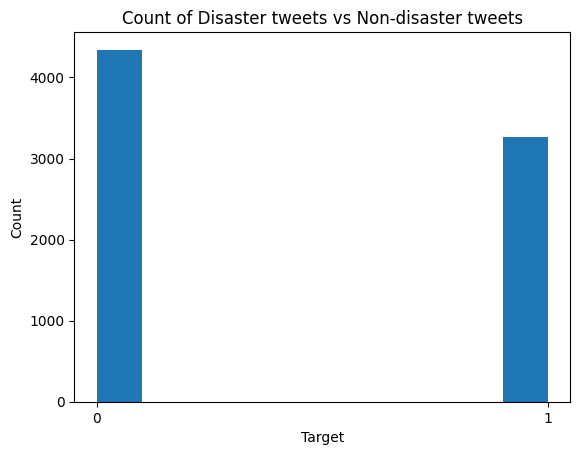

In [5]:
plt.hist(training_data['target'])

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Count of Disaster tweets vs Non-disaster tweets')
plt.xticks([0, 1])

plt.show()

#### Generate the word cloud for most common words

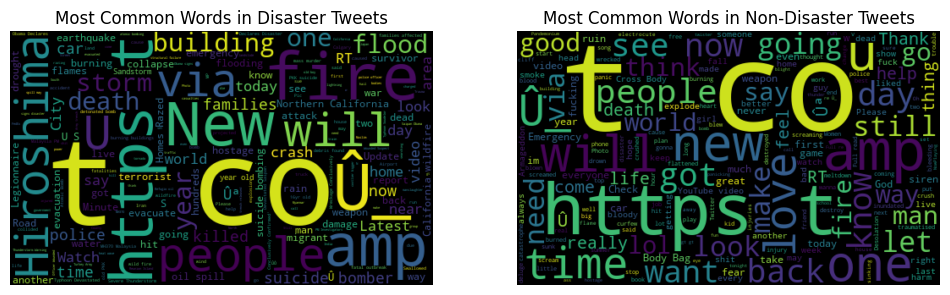

In [6]:
# Generate word clouds for disaster and non-disaster tweets
disaster_text = " ".join(training_data[training_data["target"] == 1]["text"])
non_disaster_text = " ".join(training_data[training_data["target"] == 0]["text"])

plt.figure(figsize=(12, 5))

# Disaster tweets word cloud
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=500, height=300, background_color="black").generate(disaster_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Disaster Tweets")

# Non-disaster tweets word cloud
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=500, height=300, background_color="black").generate(non_disaster_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Non-Disaster Tweets")

plt.show()

#### Find commonly presents hashtags in the tweets

In [7]:
# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Extract hashtags from disaster and non-disaster tweets
disaster_hashtags = sum(training_data[training_data["target"] == 1]["text"].apply(extract_hashtags), [])
non_disaster_hashtags = sum(training_data[training_data["target"] == 0]["text"].apply(extract_hashtags), [])

# Count most common hashtags
disaster_hashtag_counts = collections.Counter(disaster_hashtags).most_common(10)
non_disaster_hashtag_counts = collections.Counter(non_disaster_hashtags).most_common(10)

print("Top 10 Hashtags in Disaster Tweets:", disaster_hashtag_counts, end="\n\n\n")

print("Top 10 Hashtags in Non-Disaster Tweets:", non_disaster_hashtag_counts)

Top 10 Hashtags in Disaster Tweets: [('News', 33), ('news', 23), ('Hiroshima', 21), ('hot', 13), ('prebreak', 13), ('best', 13), ('Japan', 10), ('India', 10), ('yyc', 10), ('Sismo', 9)]


Top 10 Hashtags in Non-Disaster Tweets: [('hot', 18), ('prebreak', 17), ('best', 17), ('news', 15), ('GBBO', 13), ('islam', 11), ('NowPlaying', 10), ('nowplaying', 10), ('jobs', 9), ('EDM', 8)]


#### Check for the present URLs

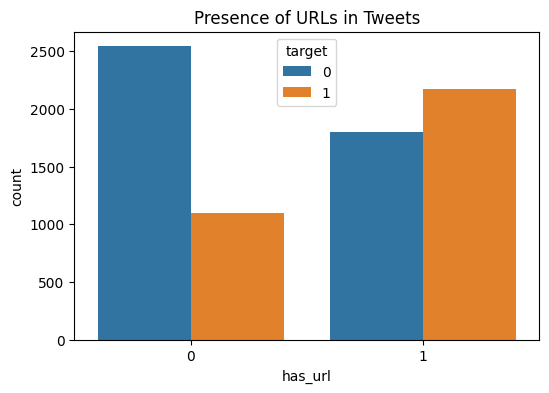

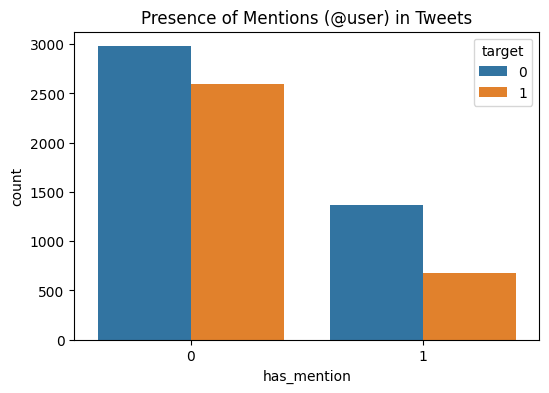

In [8]:
# Count presence of URLs and mentions
training_data["has_url"] = training_data["text"].apply(lambda x: 1 if "http" in x else 0)
training_data["has_mention"] = training_data["text"].apply(lambda x: 1 if "@" in x else 0)

# Plot URL presence
plt.figure(figsize=(6, 4))
sns.countplot(x="has_url", hue="target", data=training_data)
plt.title("Presence of URLs in Tweets")
plt.show()

# Plot mentions presence
plt.figure(figsize=(6, 4))
sns.countplot(x="has_mention", hue="target", data=training_data)
plt.title("Presence of Mentions (@user) in Tweets")
plt.show()

#### Find the general text length

In [9]:
training_data["text_length"] = training_data["text"].apply(lambda x: len(x))
print("Real disaster tweet length", training_data[training_data['target'] == 1]['text_length'].mean())
print("Fake disaster tweet length", training_data[training_data['target'] == 0]['text_length'].mean())

Real disaster tweet length 108.11342097217977
Fake disaster tweet length 95.70681713496084


In [10]:
training_data.drop(['has_url', 'has_mention', 'text_length'], axis=1, inplace=True)

### Spliting dataset into training and validation

In [11]:
X_train, X_val, y_train, y_val = train_test_split(training_data.drop('target', axis=1), training_data['target'], test_size=0.2, random_state=123)

### Data preprocessing

In [12]:
def preprocess_text(text):
    """ Function to convert text data into a format suitable for ML tasks.
    """
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back into string
    return ' '.join(tokens)

In [13]:
# Wrapper function to apply preprocessing to the 'text' column
def apply_pre_processing(X):
    # Expecting X to be a DataFrame or Series
    if isinstance(X, pd.DataFrame):
        return X['text'].apply(preprocess_text)
    elif isinstance(X, pd.Series):
        return X.apply(preprocess_text)
    elif isinstance(X, list):
        return [preprocess_text(x) for x in X]
    else:
        raise TypeError("Input should be a DataFrame, Series, or list of texts")

#### Text preprocessing pipeline

In [14]:
text_pre_processing_transformer = FunctionTransformer(apply_pre_processing, validate=False)
pre_processing_pipeline = Pipeline([('custom_transform', text_pre_processing_transformer)])

## Dummy Classifier:

##### !Note: For dummy classifier, since it is always going to pick the majority class for it's prediction. We are only going to train dummy classifier with Count Vectorizer encoding technique.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier

dummy_count_vectorizer_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('count_vectorizer', CountVectorizer()), ('dummy_classifier', DummyClassifier(strategy="most_frequent"))])

In [16]:
dummy_count_vectorizer_pipe.fit(X_train, y_train)

Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('count_vectorizer', CountVectorizer()),
                ('dummy_classifier',
                 DummyClassifier(strategy='most_frequent'))])

In [17]:
dummy_count_vectorizer_pipe.predict(X_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [18]:
print("Dummy Vectorizer + Count Vectorizer: ", dummy_count_vectorizer_pipe.score(X_val, y_val))

Dummy Vectorizer + Count Vectorizer:  0.5771503611293499


## Logistic Regression:

#### First let's try Logistic Regression and Count Vectorizer approach

In [19]:
from sklearn.linear_model import LogisticRegression

logistic_count_vectorizer_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('count_vectorizer', CountVectorizer()), ('logistic_regression', LogisticRegression())])

logistic_count_vectorizer_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
logistic_count_vectorizer_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('count_vectorizer', CountVectorizer()),
                ('logistic_regression', LogisticRegression())])

In [20]:
print("Logistic Regression + Count Vectorizer predictions: ", logistic_count_vectorizer_pipe.predict(X_val['text']))

print("Logistic Regression + Count Vectorizer prediction score: ", logistic_count_vectorizer_pipe.score(X_val['text'], y_val))

Logistic Regression + Count Vectorizer predictions:  [1 0 0 ... 0 1 1]
Logistic Regression + Count Vectorizer prediction score:  0.7925147734734077


#### Then let's try Logistic Regression and TF-IDF approach

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

logistic_tfidf_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('tfidf', TfidfVectorizer()), ('logistic_regression', LogisticRegression())])

logistic_tfidf_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
logistic_tfidf_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('tfidf', TfidfVectorizer()),
                ('logistic_regression', LogisticRegression())])

In [22]:
print("Logistic Regression + TF-IDF predictions: ", logistic_tfidf_pipe.predict(X_val['text']))

print("Logistic Regression + TF-IDF prediction score: ", logistic_tfidf_pipe.score(X_val['text'], y_val))

Logistic Regression + TF-IDF predictions:  [1 0 0 ... 0 1 1]
Logistic Regression + TF-IDF prediction score:  0.793827971109652


### Now let's get the sentence vectors for training and testinbg using Word2Vec approach

In [23]:
# Importing required libraries for word2vec
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize

#### Here a class for applying word2vec is written to get sentence vectors, so that it can be used inside sklearn pipelines

In [24]:
from sklearn.base import TransformerMixin, BaseEstimator

class apply_word2vec(BaseEstimator, TransformerMixin):
    def __init__(self, embedding_vector_size=500, window=5, min_count=1):
        self.embedding_vector_size = embedding_vector_size
        self.window = window
        self.min_count = min_count
        self.word2vec_model = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            texts = X['text']
        elif isinstance(X, pd.Series):
            texts = X
        elif isinstance(X, list):
            texts = pd.Series(X)
        else:
            raise TypeError("Input should be a DataFrame, Series, or list of texts")

        preprocessed = pre_processing_pipeline.fit_transform(texts)
        corpus = ' '.join(preprocessed)

        data = []
        for sentence in sent_tokenize(corpus):
            tokens = [word.lower() for word in word_tokenize(sentence)]
            data.append(tokens)

        self.word2vec_model = Word2Vec(sentences=data, vector_size=self.embedding_vector_size, window=self.window, min_count=self.min_count, sg=0)
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            texts = X['text']
        elif isinstance(X, pd.Series):
            texts = X
        elif isinstance(X, list):
            texts = pd.Series(X)
        else:
            raise TypeError("Input should be a DataFrame, Series, or list of texts")

        preprocessed = pre_processing_pipeline.transform(texts)

        vectors = []
        for sentence in preprocessed:
            tokens = sentence.split()
            word_vectors = [self.word2vec_model.wv[word] for word in tokens if word in self.word2vec_model.wv]
            if word_vectors:
                sentence_vector = np.mean(word_vectors, axis=0)
            else:
                sentence_vector = np.zeros(self.embedding_vector_size)
            vectors.append(sentence_vector)
        return np.array(vectors)

#### Finally let's try Logistic Regression and Word2vec approach

In [25]:
w2v_transformer = apply_word2vec(embedding_vector_size=500)
logistic_w2v_pipe = Pipeline([('word2vec', w2v_transformer), ('logistic_regression', LogisticRegression())])

logistic_w2v_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
logistic_w2v_pipe

Pipeline Architecture: 


Pipeline(steps=[('word2vec', apply_word2vec()),
                ('logistic_regression', LogisticRegression())])

In [26]:
print("Logistic Regression + Word2Vec predictions: ", logistic_w2v_pipe.predict(X_val['text']))

print("Logistic Regression + Word2Vec prediction score: ", logistic_w2v_pipe.score(X_val['text'], y_val))

Logistic Regression + Word2Vec predictions:  [0 0 0 ... 0 0 0]
Logistic Regression + Word2Vec prediction score:  0.5771503611293499


##### !Note: here Word2Vec is generating sentence vectors of dimension 500. Where each dimension is used as a feature to train model, and as Logistic Regression is not able to handle such huge dimensions, it's performance is similar to dummy classifier. We can reduce the word embedding dimensions, and see some improvement with Logistic Regression's result. But it was observed that with large word embedding dimension SVM and XGBoost are performing comparatively better.

##### !Note: From the following code, we can see that reducing the vector dimension, increases Logistic Regression's performance. Implying now model is able to learn some patterns from the dataset.

In [27]:
w2v_transformer = apply_word2vec(embedding_vector_size=90)
logistic_w2v_pipe = Pipeline([('word2vec', w2v_transformer), ('logistic_regression', LogisticRegression(class_weight='balanced'))])
logistic_w2v_pipe.fit(X_train['text'], y_train)
print("Logistic Regression + Word2Vec prediction score: ", logistic_w2v_pipe.score(X_val['text'], y_val))

Logistic Regression + Word2Vec prediction score:  0.6231122783978988


## Support Vector Machine (SVM):

#### Now let's SVM and Count Vectorizer approach

In [28]:
from sklearn.svm import SVC

svm_count_vectorizer_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('count_vectorizer', CountVectorizer()), ('svm', SVC())])

svm_count_vectorizer_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
svm_count_vectorizer_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('count_vectorizer', CountVectorizer()), ('svm', SVC())])

In [29]:
print("SVM + Count Vectorizer predictions: ", svm_count_vectorizer_pipe.predict(X_val['text']))

print("SVM + Count Vectorizer prediction score: ", svm_count_vectorizer_pipe.score(X_val['text'], y_val))

SVM + Count Vectorizer predictions:  [1 0 0 ... 0 1 0]
SVM + Count Vectorizer prediction score:  0.7977675640183848


#### Then let's try SVM and TF-IDF approach

In [30]:
svm_tfidf_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('tfidf', TfidfVectorizer()), ('svm', SVC())])

svm_tfidf_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
svm_tfidf_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('tfidf', TfidfVectorizer()), ('svm', SVC())])

In [31]:
print("SVM + TF-IDF predictions: ", svm_tfidf_pipe.predict(X_val['text']))

print("SVM + TF-IDF prediction score: ", svm_tfidf_pipe.score(X_val['text'], y_val))

SVM + TF-IDF predictions:  [1 0 0 ... 0 1 1]
SVM + TF-IDF prediction score:  0.7971109652002626


#### Finally let's try SVM and Word2vec approach

In [32]:
w2v_transformer = apply_word2vec(embedding_vector_size=500)
svm_w2v_pipe = Pipeline([('word2vec', w2v_transformer), ('svm', SVC())])

svm_w2v_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
svm_w2v_pipe

Pipeline Architecture: 


Pipeline(steps=[('word2vec', apply_word2vec()), ('svm', SVC())])

In [33]:
print("SVM + Word2Vec predictions: ", svm_w2v_pipe.predict(X_val['text']))

print("SVM + Word2Vec prediction score: ", svm_w2v_pipe.score(X_val['text'], y_val))

SVM + Word2Vec predictions:  [0 0 0 ... 0 1 1]
SVM + Word2Vec prediction score:  0.778069599474721


##### !Note: As SVM is able to handle larger dimensional data, we can see some pretty good improvements in SVM's performance compared to Logistic Regression.

## XGBoost Classifeir

#### Now let's XGB and Count Vectorizer approach

In [34]:
from xgboost import XGBClassifier

xgb_count_vectorizer_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('count_vectorizer', CountVectorizer()), ('xgb', XGBClassifier())])

xgb_count_vectorizer_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
xgb_count_vectorizer_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('count_vectorizer', CountVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=Fal...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [35]:
print("XGB Classifeir + Count Vectorizer predictions: ", xgb_count_vectorizer_pipe.predict(X_val['text']))

print("XGB Classifeir + Count Vectorizer prediction score: ", xgb_count_vectorizer_pipe.score(X_val['text'], y_val))

XGB Classifeir + Count Vectorizer predictions:  [0 0 0 ... 0 1 0]
XGB Classifeir + Count Vectorizer prediction score:  0.7767564018384767


#### Then let's try XGB and TF-IDF approach

In [36]:
xgb_tfidf_pipe = Pipeline([('custom_preprocessing', text_pre_processing_transformer), ('tfidf', TfidfVectorizer()), ('xgb', XGBClassifier())])

xgb_tfidf_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
xgb_tfidf_pipe

Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('tfidf', TfidfVectorizer()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_met...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [37]:
print("XGB Classifier + TF-IDF predictions: ", xgb_tfidf_pipe.predict(X_val['text']))

print("XGB Classifier + TF-IDF prediction score: ", xgb_tfidf_pipe.score(X_val['text'], y_val))

XGB Classifier + TF-IDF predictions:  [0 0 0 ... 0 1 0]
XGB Classifier + TF-IDF prediction score:  0.7721602101116218


#### Finally let's try XGB and Word2vec approach

In [38]:
w2v_transformer = apply_word2vec(embedding_vector_size=500)
xgb_w2v_pipe = Pipeline([('word2vec', w2v_transformer), ('xgb', XGBClassifier())])

xgb_w2v_pipe.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
xgb_w2v_pipe

Pipeline Architecture: 


Pipeline(steps=[('word2vec', apply_word2vec()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [39]:
print("XGB Classifier + Word2Vec predictions: ", xgb_w2v_pipe.predict(X_val['text']))

print("XGB Classifier + Word2Vec prediction score: ", xgb_w2v_pipe.score(X_val['text'], y_val))

XGB Classifier + Word2Vec predictions:  [0 0 0 ... 0 1 1]
XGB Classifier + Word2Vec prediction score:  0.7321076822061721


### Now, comparing performances of all appraoches:

In [40]:
def compare_models(models: dict, X_val, y_val):
    results = []

    for name, model in models.items():
        try:
            score = model.score(X_val, y_val)
            results.append({'Model': name, 'Validation Accuracy': round(score, 4)})
        except Exception as e:
            results.append({'Model': name, 'Validation Accuracy': 'Error', 'Error': str(e)})

    return pd.DataFrame(results).sort_values(by='Validation Accuracy', ascending=False, na_position='last').reset_index(drop=True)

models_to_compare = {
    'Logistic + Count Vectorizer': logistic_count_vectorizer_pipe,
    'SVM + Count Vectorizer': svm_count_vectorizer_pipe,
    'XGB + Count Vectorizer': xgb_count_vectorizer_pipe,

    'Logistic + TF-IDF': logistic_tfidf_pipe,
    'SVM + TF-IDF': svm_tfidf_pipe,
    'XGB + TF-IDF': xgb_tfidf_pipe,

    'Logistic + W2V': logistic_w2v_pipe,
    'SVM + W2V': svm_w2v_pipe,
    'XGB + W2V': xgb_w2v_pipe,

    'Dummy Classifeir': dummy_count_vectorizer_pipe
}

compare_models(models_to_compare, X_val['text'], y_val)


,Model,Validation Accuracy
0,SVM + Count Vectorizer,0.7978
1,SVM + TF-IDF,0.7971
2,Logistic + TF-IDF,0.7938
3,Logistic + Count Vectorizer,0.7925
4,SVM + W2V,0.7781
5,XGB + Count Vectorizer,0.7768
6,XGB + TF-IDF,0.7722
7,XGB + W2V,0.7321
8,Logistic + W2V,0.6231
9,Dummy Classifeir,0.5772


### From these results we can see that the best perfomring model's score is about 22% more than baseline performance (dummy classifier). Which indicates significant improvemnent.

## Gridsearch on the best model with 5 fold CV


Here we perform a grid search to fine 2 seperate models
1. The count vectorizer
2. The svm model


In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

# Step 1: Define the ML pipeline with preprocessing, feature extraction, and classifier
svm_count_vectorizer_pipe = Pipeline([
    ('custom_preprocessing', text_pre_processing_transformer),  # Custom transformer to clean text
    ('count_vectorizer', CountVectorizer()),                    # Convert text to bag-of-words vectors
    ('svm', SVC())                                              # Support Vector Classifier
])

# Step 2: Define a grid of hyperparameters to tune
param_grid = {
    'count_vectorizer__max_features': [500, 1000, 2000],       # Vocabulary size options
    'count_vectorizer__ngram_range': [(1, 1), (1, 2)],         # Use unigrams or bigrams
    'svm__C': [0.1, 1, 10],                                    # Regularization strength
    'svm__kernel': ['linear', 'rbf']                           # Kernel types for SVM
}

# Step 3: Set up grid search with 5-fold cross-validation
# - scoring: 'f1_macro' ensures class imbalance is handled
# - n_jobs=1 avoids parallel processing issues with custom transformers
grid_search = GridSearchCV(
    estimator=svm_count_vectorizer_pipe,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=1,
    verbose=2
)

# Step 4: Fit the grid search on training data to find the best parameter combination
grid_search.fit(X_train['text'], y_train)

# Step 5: Print the best parameters and best cross-validated F1-score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Step 6: Evaluate the final model on the hold-out validation set
print("Validation set accuracy: ", grid_search.score(X_val['text'], y_val))



Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=linear; total time=   1.8s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=linear; total time=   1.8s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=linear; total time=   1.9s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=linear; total time=   1.7s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=linear; total time=   1.7s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=rbf; total time=   2.1s
[CV] END count_vectorizer__max_features=500, count_vectorizer__ngram_range=(1, 1), svm__C=0.1, svm__kernel=rbf; total time=   2.0s
[CV] E

## Grid Search Visualisation



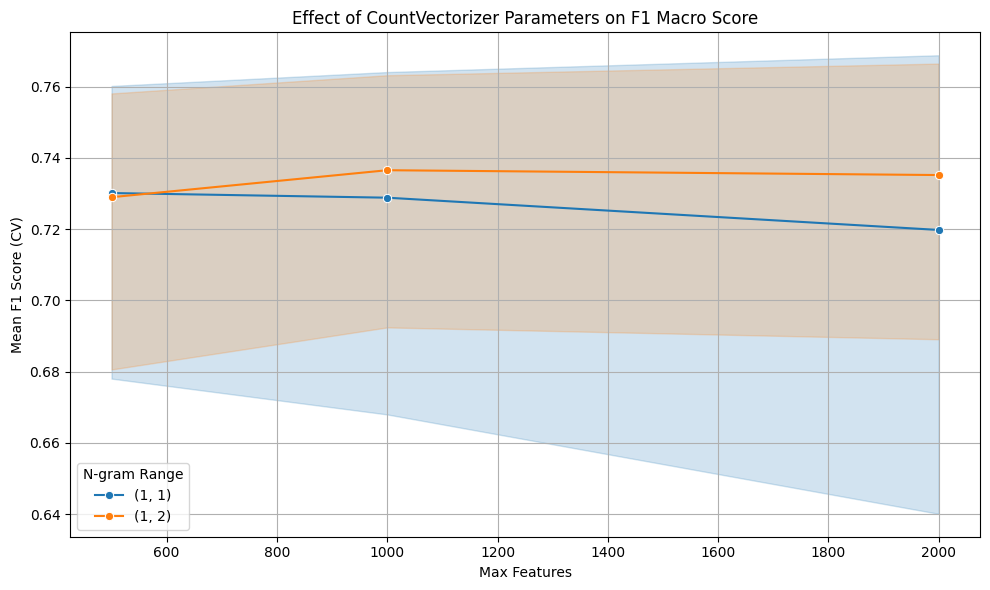

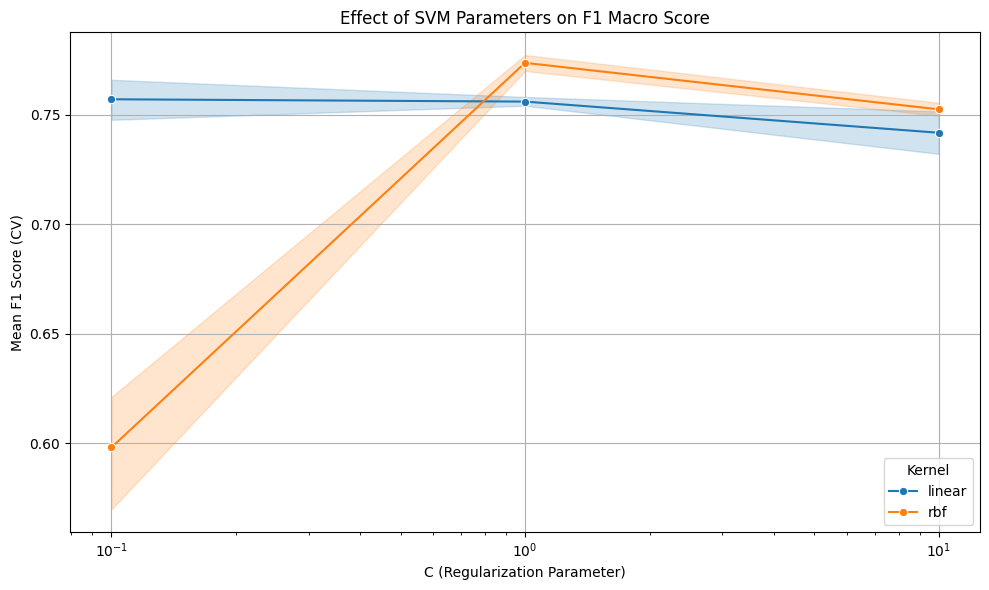

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert grid search results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# =======================
# 1. CountVectorizer Effects
# =======================
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="param_count_vectorizer__max_features",
    y="mean_test_score",
    hue="param_count_vectorizer__ngram_range",
    marker="o"
)
plt.title("Effect of CountVectorizer Parameters on F1 Macro Score")
plt.xlabel("Max Features")
plt.ylabel("Mean F1 Score (CV)")
plt.grid(True)
plt.legend(title="N-gram Range")
plt.tight_layout()
plt.show()

# =======================
# 2. SVM Parameter Effects
# =======================
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x="param_svm__C",
    y="mean_test_score",
    hue="param_svm__kernel",
    marker="o"
)
plt.title("Effect of SVM Parameters on F1 Macro Score")
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Mean F1 Score (CV)")
plt.xscale("log")  # Use log scale for better separation
plt.grid(True)
plt.legend(title="Kernel")
plt.tight_layout()
plt.show()


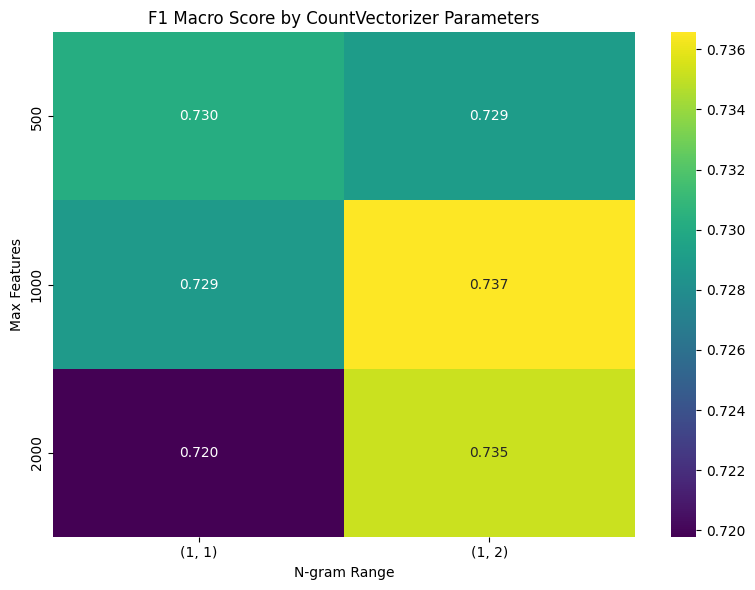

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create pivot table for CountVectorizer heatmap
cv_pivot = results_df.pivot_table(
    index="param_count_vectorizer__max_features",
    columns="param_count_vectorizer__ngram_range",
    values="mean_test_score"
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cv_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("F1 Macro Score by CountVectorizer Parameters")
plt.xlabel("N-gram Range")
plt.ylabel("Max Features")
plt.tight_layout()
plt.show()


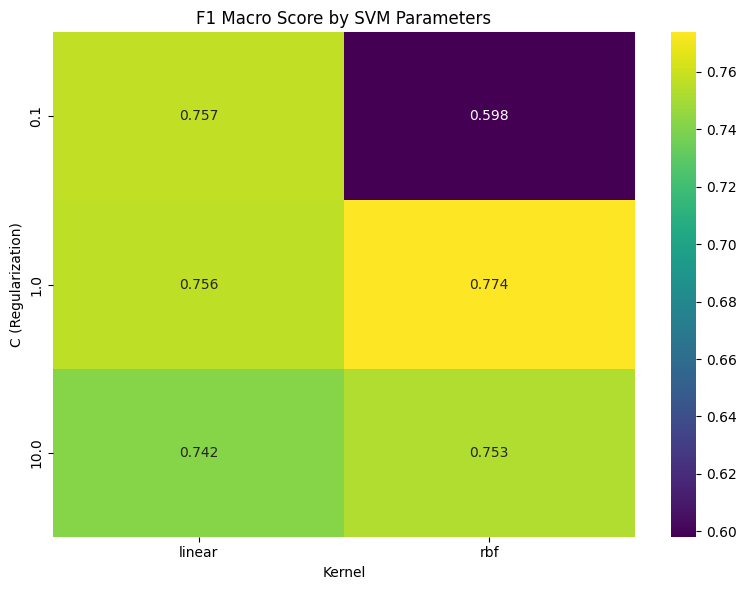

In [44]:
# Create pivot table for SVM heatmap
svm_pivot = results_df.pivot_table(
    index="param_svm__C",
    columns="param_svm__kernel",
    values="mean_test_score"
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(svm_pivot, annot=True, fmt=".3f", cmap="viridis")
plt.title("F1 Macro Score by SVM Parameters")
plt.xlabel("Kernel")
plt.ylabel("C (Regularization)")
plt.tight_layout()
plt.show()


# Final Model
Here we train and fit our final model using the best hyper parameters we found.

In [45]:
final_svm_pipeline = Pipeline([
    ('custom_preprocessing', text_pre_processing_transformer),
    ('count_vectorizer', CountVectorizer(max_features=2000, ngram_range=(1, 1))),
    ('svm', SVC(C=1, kernel='rbf'))
])
final_svm_pipeline.fit(X_train['text'], y_train)

print("Pipeline Architecture: ")
final_svm_pipeline


Pipeline Architecture: 


Pipeline(steps=[('custom_preprocessing',
                 FunctionTransformer(func=<function apply_pre_processing at 0x000001B789D6C680>)),
                ('count_vectorizer', CountVectorizer(max_features=2000)),
                ('svm', SVC(C=1))])

In [46]:
print("SVM + Count Vectorizer predictions: ", final_svm_pipeline.predict(X_val['text']))
print("SVM + Count Vectorizer prediction score: ", final_svm_pipeline.score(X_val['text'], y_val))

SVM + Count Vectorizer predictions:  [1 0 0 ... 0 1 0]
SVM + Count Vectorizer prediction score:  0.8010505581089954


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on the validation set
y_pred = final_svm_pipeline.predict(X_val['text'])

# Print classification report
# Define class names in order of labels
class_names = ['Not Disaster', 'Disaster']  # if your labels are 0 and 1
print("SVM + Count Vectorizer Classification Report:")
print(classification_report(y_val, y_pred, target_names=class_names))

SVM + Count Vectorizer Classification Report:
SVM + Count Vectorizer Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.78      0.91      0.84       879
    Disaster       0.85      0.65      0.73       644

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.80      1523



#### Making predictions on (holdout) Test dataset, which will be passed to the Kaggle (Natural Language Processing with Disaster Tweets) competition

#### Loading testing data

In [48]:
testing_data = pd.read_csv("./nlp-getting-started/test.csv")
testing_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [49]:
testing_data['target'] = final_svm_pipeline.predict(testing_data['text'])
testing_data.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,0
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [50]:
testing_data.drop(['keyword', 'location', 'text'], axis =1, inplace=True)
testing_data.to_csv("Final_predictions.csv", index=False)

### We acheived 79.28% F1-score on this testing dataset.

#### Hence, we can conclude that the selected model — SVM + CountVectorizer and tuned hyperparameters — generalizes well to unseen data and performs consistently across both validation and test sets. The relatively small gap between validation and test accuracy suggests the model is not overfitting and is robust for the tweet classification task. This supports our hypothesis that simpler vectorization methods like CountVectorizer, when paired with a well-tuned SVM, can outperform more complex approaches for short-text classification problems.